## 1. Data preparation

In [1]:
# https://figshare.com/articles/dataset/MACCROBAT2018/9764942
# https://brat.nlplab.org/standoff.html

In [2]:
!mkdir MACCROBAT2018

In [3]:
!unzip /content/MACCROBAT2018.zip -d ./MACCROBAT2018

unzip:  cannot find or open /content/MACCROBAT2018.zip, /content/MACCROBAT2018.zip.zip or /content/MACCROBAT2018.zip.ZIP.


In [ ]:
!pip -q install evaluate accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


+ Mô tả về dataset và cách xử lí file
+ Có hai file là file text chứa đoạn văn bản và file ann
    Ví dụ về file ann : Loại entity   Type index_start index_end text
    Đưa về nguyên đoạn văn với index vànhãn tương ứng
    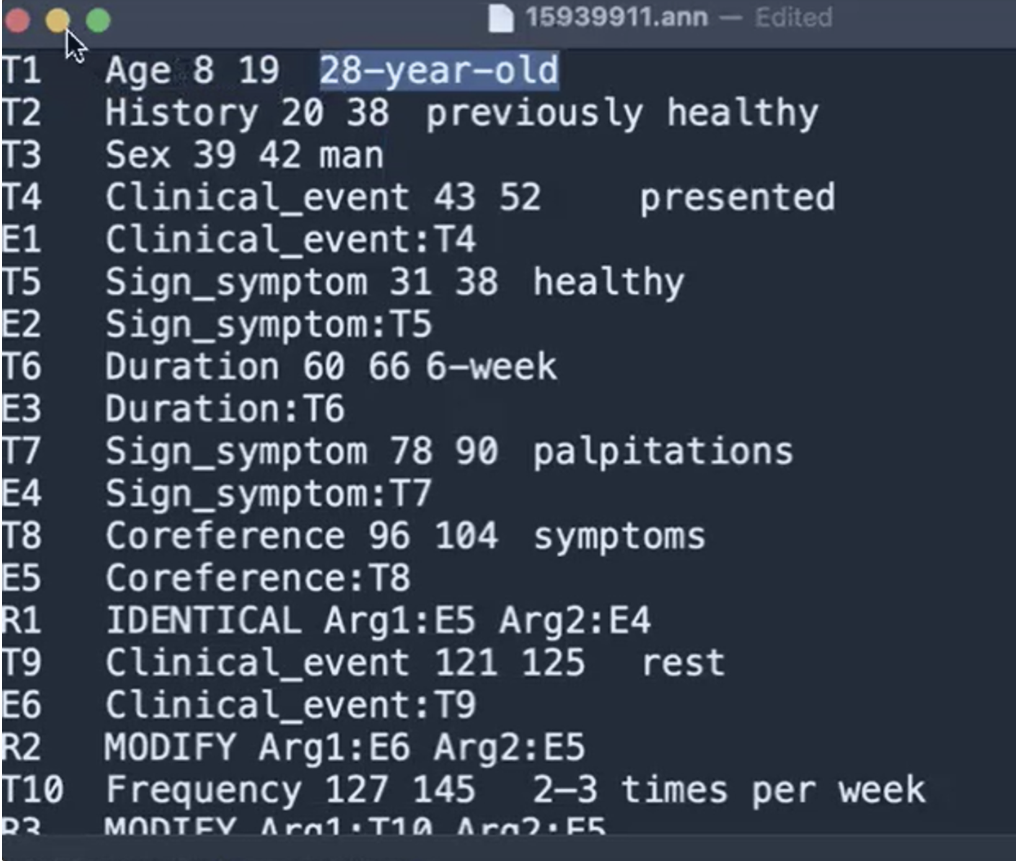

In [ ]:
import os
from typing import List, Dict, Tuple

class Preprocessing_Maccrobat:
    def __init__(self, dataset_folder, tokenizer):
        self.tokenizer = tokenizer
        self.file_ids = [f.split(".")[0] for f in os.listdir(dataset_folder) if f.endswith('.txt')]

        self.text_files = [f+".txt" for f in self.file_ids]
        self.anno_files = [f+".ann" for f in self.file_ids]

        self.num_samples = len(self.file_ids)
        self.texts = []
        for i in range(self.num_samples):
            file_path = os.path.join(dataset_folder, self.text_files[i])
            with open(file_path, 'r') as f:
                self.texts.append(f.read())
        self.tags = []
        for i in range(self.num_samples):
            file_path = os.path.join(dataset_folder, self.anno_files[i])
            with open(file_path, 'r') as f:
                text_bound_bnn = [t.split("\t") for t in f.read().split("\n") if t.startswith("T")]
                text_bnns = []
                for text_b in text_bound_bnn:
                    label = text_b[1].split(" ")
                    try:
                        _ = int(label[1])
                        _ = int(label[2])
                        tag = {
                            'text':text_b[-1],
                            'label':label[0],
                            'start':label[1],
                            'end':label[2]
                        }
                        print(tag)
                        text_bnns.append(tag) # 28-year-old, Age, 8, 19
                    except:
                        pass
                self.tags.append(text_bnns)

    def process(self) -> Tuple[List[List[str]], List[List[str]]]:
        # we are learning 0 => 14
        # B-Per I-Per O 0,1 --- 3, 4, 5 --- 7, 8,...14
        input_texts = []
        input_labels = []

        for idx in range(self.num_samples):
            full_text = self.texts[idx]
            tags = self.tags[idx]
            # 4 => 6, ko có trong thực thể: 0, 1, 2, 3  --- 7, 8

            label_offset = []
            continue_label_offset = []
            for tag in tags:
                offset = list(range(int(tag["start"]), int(tag["end"])+1)) # 4 5 6
                label_offset.append(offset)
                continue_label_offset.append(offset)

            all_offset = list(range(len(full_text)))
            zero_offset = [offset for offset in all_offset if offset not in continue_label_offset] # 0, 1, 2, 3, 7, 8
            zero_offset = Preprocessing_Maccrobat.find_continuous_ranges(zero_offset)

            self.tokens = []
            self.labels = []
            self._merge_offset(full_text, tags, zero_offset, label_offset)

            input_texts.append(self.tokens)
            input_labels.append(self.labels)

        return input_texts, input_labels

    def _merge_offset(self, full_text, tags, zero_offset, label_offset):
        # zero_offset = [[0, 1, 2, 3], [7, 8], [9, 10]]
        # label_offset = [[4, 5, 6]]
        i = j = 0

        while i < len(zero_offset) and j < len(label_offset):
            if zero_offset[i][0] < label_offset[j][0]:
                self._add_zero(full_text, zero_offset, i) # [0, 1, 2, 3]
                i += 1
            else:
                self._add_label(full_text, label_offset, j, tags)
                j += 1

        while i < len(zero_offset):
            self._add_zero(full_text, zero_offset, i)
            i += 1

        while j < len(label_offset):
            self._add_label(full_text, label_offset, j, tags)
            j += 1

    def _add_zero(self, full_text, offset, index): # 0, 1, 2, 3
        start, *_, end = offset[index] if len(offset[index]) > 1 else (offset[index][0], offset[index][0]+1)
        text = full_text[start:end]
        text_tokens = self.tokenizer.tokenize(text) # we are => we, are

        self.tokens.extend(text_tokens)
        self.labels.extend(
            ["O"]*len(text_tokens) # O, O, B-Per I-Per I-Per,...
        )

    def _add_label(self, full_text, offset, index, tags):
        start, *_, end = offset[index] if len(offset[index]) > 1 else (offset[index][0], offset[index][0]+1)
        text = full_text[start:end]
        text_tokens = self.tokenizer.tokenize(text) # we are => we, are, lear...

        self.tokens.extend(text_tokens)
        self.labels.extend(
            [f"B-{tags[index]['label']}"] + [f"I-{tags[index]['label']}"]*(len(text_tokens)-1)
        )

    @staticmethod
    def build_label2id(tokens: List[List[str]]):
        label2id = {}
        id_counter = 0
        for token in [token for sublist in tokens for token in sublist]:
            if token not in label2id:
                label2id[token] = id_counter
                id_counter += 1
        return label2id

    @staticmethod
    def find_continuous_ranges(data: List[int]): # 0, 1, 2, 3, 7, 8
        if not data:
            return []
        ranges = []
        start = data[0]
        prev = data[0]
        for number in data[1:]:
            if number != prev + 1:
                ranges.append(list(range(start, prev + 1)))
                start = number
            prev = number
        ranges.append(list(range(start, prev + 1)))
        return ranges # [[0, 1, 2, 3], [7, 8]]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")

dataset_folder = "./MACCROBAT2018"

Maccrobat_builder = Preprocessing_Maccrobat(dataset_folder, tokenizer)
input_texts, input_labels = Maccrobat_builder.process()

label2id = Preprocessing_Maccrobat.build_label2id(input_labels)
id2label = {v: k for k, v in label2id.items()}

Streaming output truncated to the last 5000 lines.
['Diagnostic_procedure', '2004', '2008']
{'text': 'CD34', 'label': 'Diagnostic_procedure', 'start': '2004', 'end': '2008'}
['Diagnostic_procedure', '2010', '2029']
{'text': 'smooth muscle actin', 'label': 'Diagnostic_procedure', 'start': '2010', 'end': '2029'}
['Diagnostic_procedure', '2031', '2034']
{'text': 'SMA', 'label': 'Diagnostic_procedure', 'start': '2031', 'end': '2034'}
['Diagnostic_procedure', '2041', '2044']
{'text': 'ALK', 'label': 'Diagnostic_procedure', 'start': '2041', 'end': '2044'}
['Lab_value', '2050', '2066']
{'text': 'focally positive', 'label': 'Lab_value', 'start': '2050', 'end': '2066'}
['Diagnostic_procedure', '2093', '2102']
{'text': 'cyclin D1', 'label': 'Diagnostic_procedure', 'start': '2093', 'end': '2102'}
['Diagnostic_procedure', '2104', '2110']
{'text': 'desmin', 'label': 'Diagnostic_procedure', 'start': '2104', 'end': '2110'}
['Diagnostic_procedure', '2115', '2129']
{'text': 'pancytokeratin', 'label': '

Token indices sequence length is longer than the specified maximum sequence length for this model (842 > 512). Running this sequence through the model will result in indexing errors
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
input_texts[0][:10]

['a', '60', '-', 'year', '-', 'old', 'white', 'brazilian', 'man', ',']

In [ ]:
input_labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O'

## 2. Dataset loader

In [ ]:
from sklearn.model_selection import train_test_split


inputs_train, inputs_val, labels_train, labels_val = train_test_split(
    input_texts,
    input_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
import torch
from torch.utils.data import Dataset

MAX_LEN = 512

class NER_Dataset(Dataset):
    def __init__(self, input_texts, input_labels, tokenizer, label2id, max_len=MAX_LEN):
        super().__init__()
        self.tokens = input_texts
        self.labels = input_labels
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        input_token = self.tokens[idx]
        label_token = [self.label2id[label] for label in self.labels[idx]]

        input_token = self.tokenizer.convert_tokens_to_ids(input_token)
        attention_mask = [1] * len(input_token)

        input_ids = self.pad_and_truncate(input_token, pad_id= self.tokenizer.pad_token_id)
        labels = self.pad_and_truncate(label_token, pad_id=0)
        attention_mask =  self.pad_and_truncate(attention_mask, pad_id=0)

        return {
            "input_ids": torch.as_tensor(input_ids),
            "labels": torch.as_tensor(labels),
            "attention_mask": torch.as_tensor(attention_mask)
            }

    def pad_and_truncate(self, inputs: List[int], pad_id: int):
        if len(inputs) < self.max_len:
            padded_inputs = inputs + [pad_id] * (self.max_len - len(inputs))
        else:
            padded_inputs = inputs[:self.max_len]
        return padded_inputs

    def label2id(self, labels: List[str]):
        return [self.label2id[label] for label in labels]

In [ ]:
train_set = NER_Dataset(inputs_train, labels_train, tokenizer, label2id)
val_set = NER_Dataset(inputs_val, labels_val, tokenizer, label2id)

## 3. Model

In [ ]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "d4data/biomedical-ner-all",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)
model

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at d4data/biomedical-ner-all and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([84]) in the checkpoint and torch.Size([83]) in the model instantiated
- classifier.weight: found shape torch.Size([84, 768]) in the checkpoint and torch.Size([83, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

## 4. Training

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    mask = labels != 0
    predictions = np.argmax(predictions, axis=-1)
    return accuracy.compute(predictions=predictions[mask], references=labels[mask])

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="out_dir",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.791610,0.383468
2,No log,1.137080,0.576751
3,No log,0.852462,0.700171
4,No log,0.749603,0.736692
5,No log,0.720018,0.747453
6,No log,0.681976,0.762941
7,No log,0.667056,0.767262
8,No log,0.674602,0.767751
9,No log,0.686436,0.771664
10,No log,0.688290,0.771501


TrainOutput(global_step=200, training_loss=0.4140945053100586, metrics={'train_runtime': 151.8354, 'train_samples_per_second': 21.075, 'train_steps_per_second': 1.317, 'total_flos': 418702245888000.0, 'train_loss': 0.4140945053100586, 'epoch': 20.0})

## 5. Inference

In [ ]:
test_sentence = """A 48 year - old female presented with vaginal bleeding and abnormal Pap smears .
Upon diagnosis of invasive non - keratinizing SCC of the cervix ,
she underwent a radical hysterectomy with salpingo - oophorectomy
which demonstrated positive spread to the pelvic lymph nodes and the parametrium .
Pathological examination revealed that the tumour also extensively involved the lower uterine segment .
"""
input = torch.as_tensor([tokenizer.convert_tokens_to_ids(test_sentence.split())])

In [ ]:
input = input.to("cuda")

In [ ]:
outputs = model(input)
outputs.logits.shape

torch.Size([1, 63, 83])

In [ ]:
_, preds = torch.max(outputs.logits, -1)
preds = preds[0].cpu().numpy()

In [ ]:
for token, pred in zip(test_sentence.split(), preds):
    print(f"{token}\t{id2label[pred]}")

A	O
48	B-Age
year	I-Age
-	I-Age
old	I-Age
female	B-Sex
presented	B-Clinical_event
with	O
vaginal	O
bleeding	B-Sign_symptom
and	O
abnormal	B-Detailed_description
Pap	O
smears	O
.	O
Upon	O
diagnosis	O
of	O
invasive	B-Detailed_description
non	O
-	I-Detailed_description
keratinizing	I-Detailed_description
SCC	O
of	O
the	O
cervix	O
,	O
she	O
underwent	O
a	O
radical	O
hysterectomy	B-Detailed_description
with	O
salpingo	B-Detailed_description
-	I-Detailed_description
oophorectomy	I-Detailed_description
which	O
demonstrated	O
positive	B-Lab_value
spread	O
to	O
the	O
pelvic	O
lymph	O
nodes	O
and	O
the	O
parametrium	O
.	O
Pathological	B-Diagnostic_procedure
examination	O
revealed	O
that	O
the	O
tumour	O
also	O
extensively	O
involved	O
the	O
lower	O
uterine	O
segment	O
.	O
